In [2]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.gensim_models
data = pd.read_csv('Tweets.csv',header=0)
data.head()

C:\Users\hcy\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
overall_data = data[['airline','airline_sentiment']].groupby(['airline','airline_sentiment']).agg({'airline_sentiment':'count'})

## diving into labeled data, we can get some layout of airline_sentiment acrossing different airline companies. United airline has highest number of negative sentiments (comments).

In [4]:
overall_data

airline_sentiment
airline        airline_sentiment                   
American       negative                        1960
               neutral                          463
               positive                         336
Delta          negative                         955
               neutral                          723
               positive                         544
Southwest      negative                        1186
               neutral                          664
               positive                         570
US Airways     negative                        2263
               neutral                          381
               positive                         269
United         negative                        2633
               neutral                          697
               positive                         492
Virgin America negative                         181
               neutral                          171
               positive                         152

## get each airline corresponding total number of airline_sentiment

In [5]:
overall_data1 = data[['airline','airline_sentiment']].groupby(['airline']).agg({'airline_sentiment':'count'})
overall_data1

,airline_sentiment
airline,
American,2759
Delta,2222
Southwest,2420
US Airways,2913
United,3822
Virgin America,504


In [6]:
data1=data
neg_portion_Ame=data1[(data1['airline']=='American') & (data1['airline_sentiment']=='negative')]['airline_sentiment'].count()/\
data1[data1['airline']=='American']['airline_sentiment'].count()

neg_portion_Delta=data1[(data1['airline']=='Delta') & (data1['airline_sentiment']=='negative')]['airline_sentiment'].count()/\
data1[data1['airline']=='Delta']['airline_sentiment'].count()

neg_portion_Southwest=data1[(data1['airline']=='Southwest') & (data1['airline_sentiment']=='negative')]['airline_sentiment'].count()/\
data1[data1['airline']=='Southwest']['airline_sentiment'].count()

neg_portion_USAirways=data1[(data1['airline']=='US Airways') & (data1['airline_sentiment']=='negative')]['airline_sentiment'].count()/\
data1[data1['airline']=='US Airways']['airline_sentiment'].count()

neg_portion_United=data1[(data1['airline']=='United') & (data1['airline_sentiment']=='negative')]['airline_sentiment'].count()/\
data1[data1['airline']=='United']['airline_sentiment'].count()

neg_portion_Virgin=data1[(data1['airline']=='Virgin America') & (data1['airline_sentiment']=='negative')]['airline_sentiment'].count()/\
data1[data1['airline']=='Virgin America']['airline_sentiment'].count()

## find out portion of negtive sentiment in different airlines, data in the below shows  USA airways has highest portion of negtive sentiments. Delta and Southwest preform very well in negtive sentiments.

In [7]:
dic1={}
dic1['neg_portion_Ame']=neg_portion_Ame
dic1['neg_portion_Delta']=neg_portion_Delta
dic1['neg_portion_Southwest']=neg_portion_Southwest
dic1['neg_portion_USAirways']=neg_portion_USAirways
dic1['neg_portion_United']=neg_portion_United
dic1['neg_portion_Virgin']=neg_portion_Virgin
dic1_datafram = pd.DataFrame(dic1,index=[0]).T
dic1_datafram=dic1_datafram.reset_index()
dic1_datafram=dic1_datafram.rename(columns={'index':'neg_portion',0:'portion'})
dic1_datafram

,neg_portion,portion
0,neg_portion_Ame,0.710402
1,neg_portion_Delta,0.429793
2,neg_portion_Southwest,0.490083
3,neg_portion_USAirways,0.776862
4,neg_portion_United,0.688906
5,neg_portion_Virgin,0.359127


## Visualizing previsous data, US Airway has quite high negative sentiment precentage.

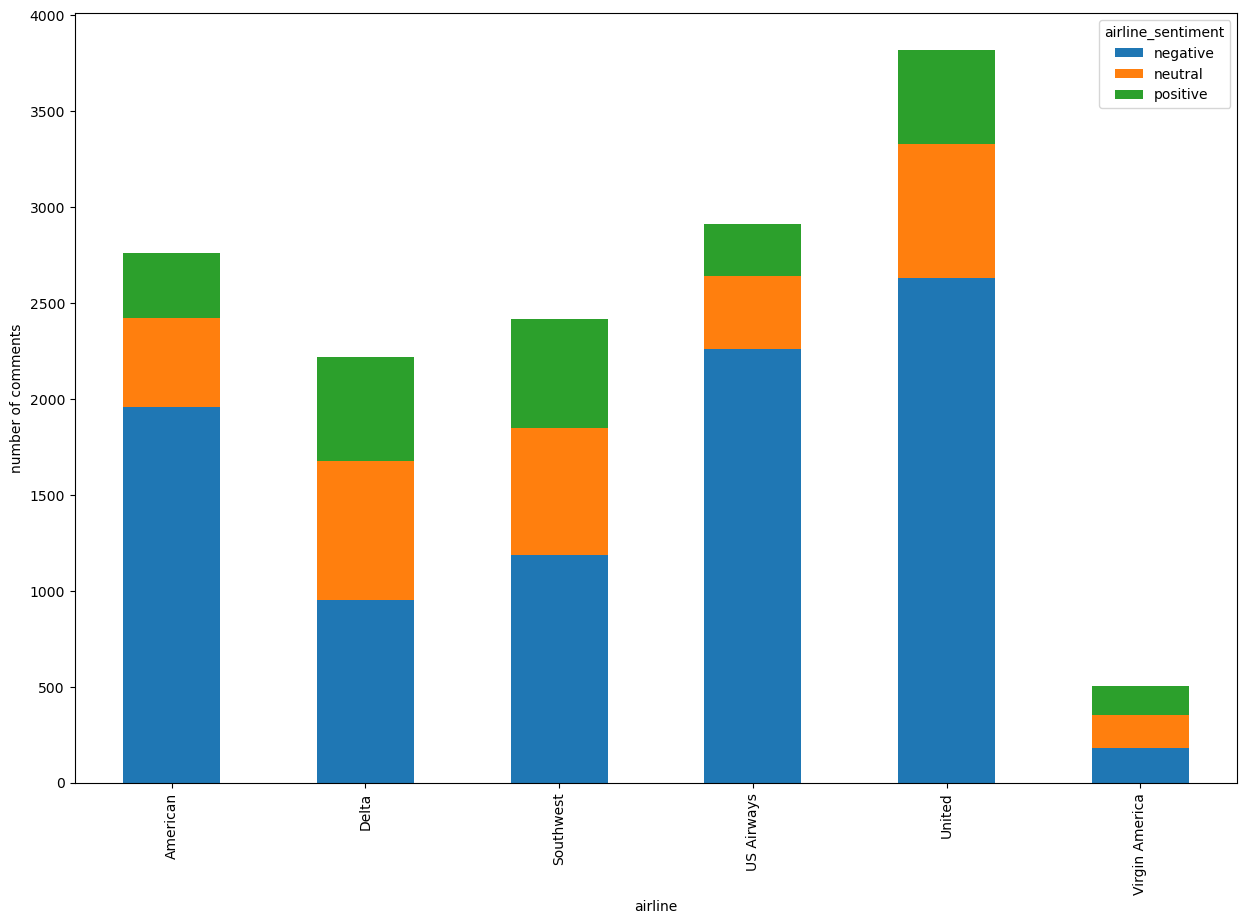

In [8]:
figure_2 = data.groupby(['airline', 'airline_sentiment']).size()
figure_2.unstack().plot(kind='bar', stacked=True, figsize=(15,10))
plt.xlabel('airline')
plt.ylabel('number of comments')
plt.show()

## After digging more in negative reason, the highest one is customer serive issue, and it's reasonable that companies which have higher customer serive issue also have more negative sentiments.

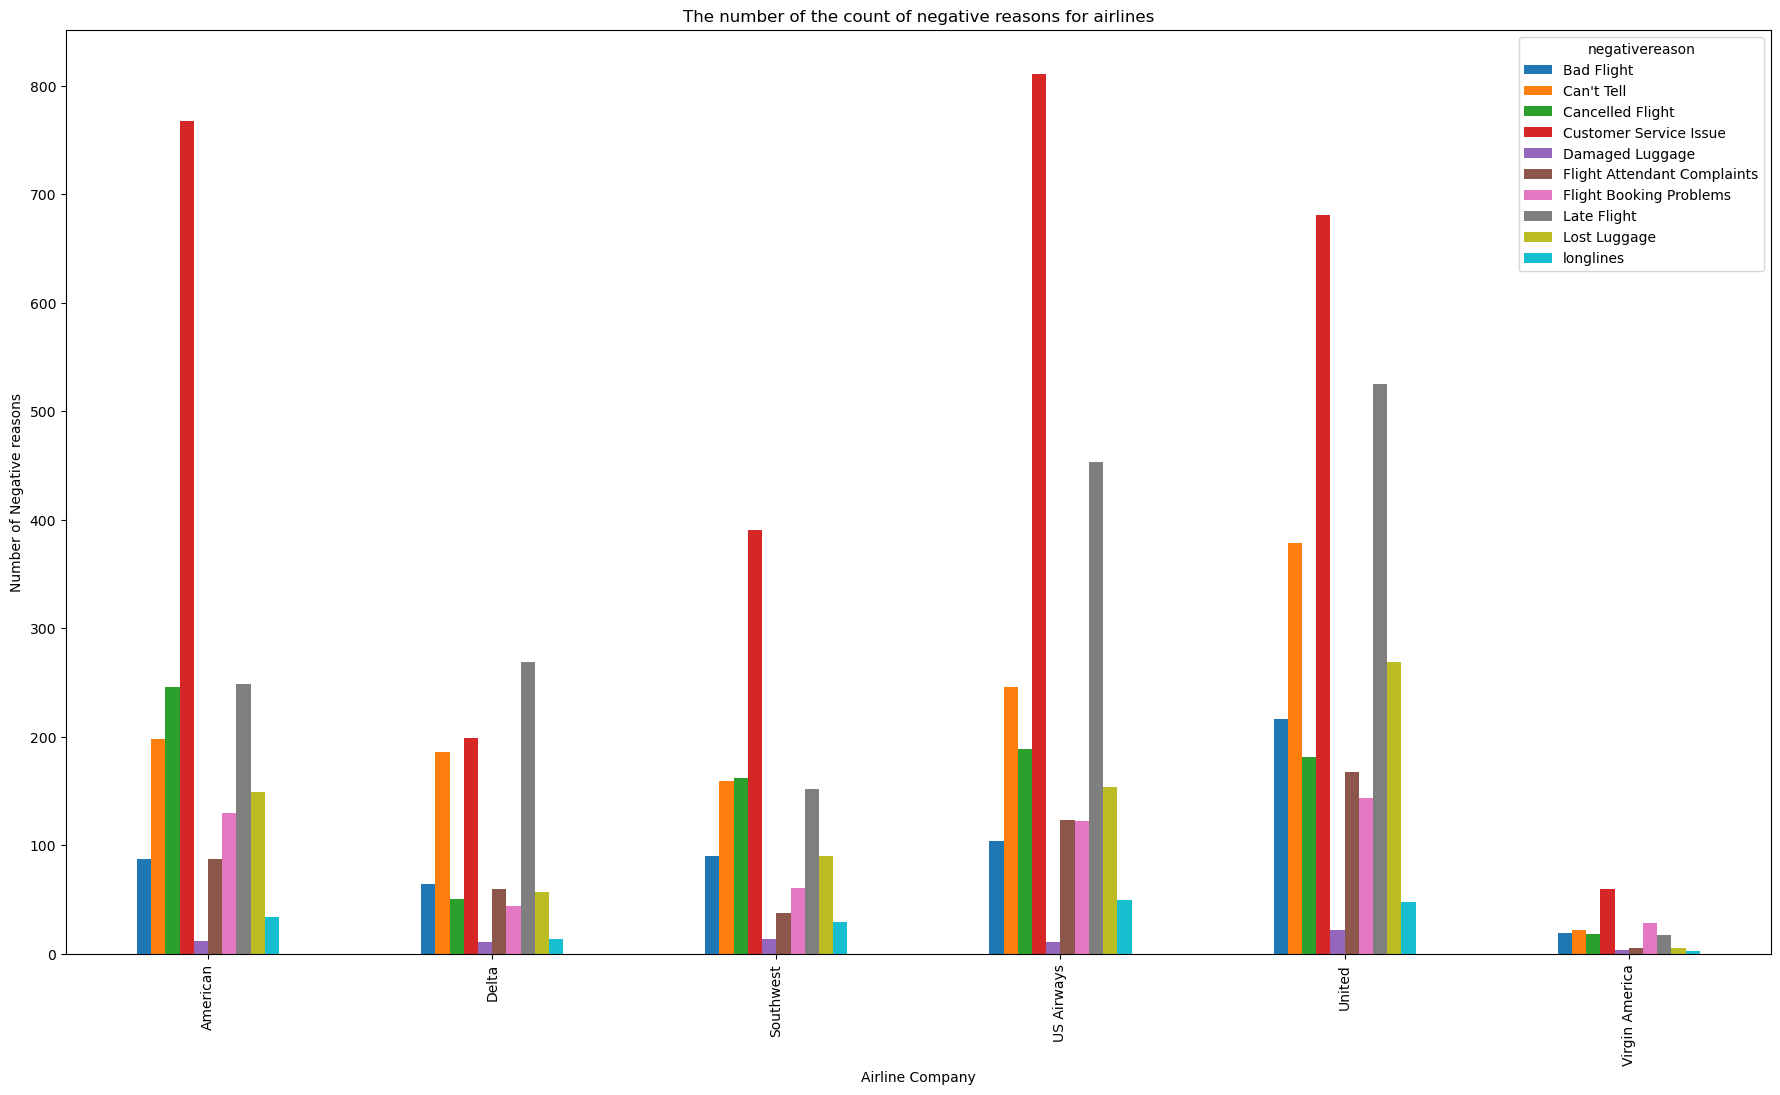

In [9]:
negative_reasons = data.groupby('airline')['negativereason'].value_counts(ascending=True)
negative_reasons.groupby(['airline','negativereason']).sum().unstack().plot(kind='bar',figsize=(22,12))
plt.xlabel('Airline Company')
plt.ylabel('Number of Negative reasons')
plt.title("The number of the count of negative reasons for airlines")
plt.show()

## Then, we begin to do modeling. At first, we slice data from orignial one and get data we need to put into modeling.

In [10]:
get_data = data[['text','airline_sentiment']]
get_data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


## We do text cleaning, to remove stopwords, '@', punctuation, lower text and tokenize text to words.

In [11]:
#text processing
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    #some words might give us something important for the sentiment analysis like not, so we keep them
    wl = ["not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in wl) and len(word) > 1] 
    return " ".join(clean_words)

def remove_mentions(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'@\w+', '', input_text[i])
    return input_text

def lower_case(input_text):
    for i in range(len(input_text)):
        input_text[i] = input_text[i].lower()
    return input_text

def remove_http(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'https?\S+', '',input_text[i])
    return input_text

def remove_punctuation(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'[^\w\s]','',input_text[i])
    return input_text
def remove_first_twowords(input_text):
    for i in range(len(input_text)):
        input_text[i] = re.sub(r'^[A-Za-z]* [A-Za-z]*','',input_text[i])
    return input_text

In [12]:
preprocessed_data = get_data.apply(remove_mentions).apply(remove_http).apply(remove_punctuation).apply(lower_case)
clean_text = []
for tweet in preprocessed_data.text:
    clean = remove_stopwords(tweet)
    clean_text.append(clean)

X = clean_text
Y = preprocessed_data['airline_sentiment']

from sklearn.model_selection import train_test_split
Y = Y.map({'negative':0, 'positive':1, 'neutral':2}).astype(int)
X_train,X_test,y_train,y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

## Here is cleaned text data.

In [13]:
clean_text1= pd.DataFrame(clean_text)
preprocessed_data['text']=clean_text1
preprocessed_data

,text,airline_sentiment
0,said,neutral
1,plus youve added commercials experience tacky,positive
2,didnt today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainmen...,negative
4,really big bad thing,negative
...,...,...
14635,thank got different flight chicago,positive
14636,leaving 20 minutes late flight no warnings com...,negative
14637,please bring american airlines blackberry10,neutral
14638,money change flight dont answer phones suggest...,negative


## Check data balance, we find our data is skewed data, we have more negative data than other two categories

In [14]:
preprocessed_data['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [15]:
Y.value_counts()

0    9178
2    3099
1    2363
Name: airline_sentiment, dtype: int64

## Covert to dtm dataframe, we set mid_df = 10, since too small mid_df bring us lots words that unrelated. In this way, we get top 10 words, since it's a big data, most words have very small dtm.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(min_df=10)
dtm = tfidf_vect.fit_transform(preprocessed_data['text'])
print("size of tfidf matrix:", dtm.shape)

size of tfidf matrix: (14640, 1756)


## Do one more step to deal with skewed data, we use oversampling technique SMOTE here to get balanced data and do a test late

In [17]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='not majority')
X_sm,y_sm=smote.fit_resample(dtm,preprocessed_data['airline_sentiment'])
y_sm.value_counts()

neutral     9178
positive    9178
negative    9178
Name: airline_sentiment, dtype: int64

In [18]:
smote = SMOTE(sampling_strategy='not majority')
X_sm1,y_sm1=smote.fit_resample(dtm,Y)
y_sm1.value_counts()

2    9178
1    9178
0    9178
Name: airline_sentiment, dtype: int64

In [19]:
X_sm.shape

(27534, 1756)

In [20]:
y_sm.shape

(27534,)

In [21]:
voc_lookup={tfidf_vect.vocabulary_[word]:word \
            for word in tfidf_vect.vocabulary_}

print("\nOriginal text: \n"+preprocessed_data["text"][0])

print("\ntfidf weights: \n")
doc0=dtm[0].toarray()[0]
print("Vectorized document shape: ", doc0.shape, "\n")

# get index of top 20 words
print("top words:")
top_words=(doc0.argsort())[::-1][0:20]
for i in top_words:
    print("{0}:\t{1:.3f}".format(voc_lookup[i], doc0[i]))


Original text: 
said

tfidf weights: 

Vectorized document shape:  (1756,) 

top words:
said:	1.000
zero:	0.000
false:	0.000
family:	0.000
fan:	0.000
fantastic:	0.000
far:	0.000
fare:	0.000
fares:	0.000
fast:	0.000
faster:	0.000
fault:	0.000
favorite:	0.000
fb:	0.000
feature:	0.000
feb:	0.000
february:	0.000
fee:	0.000
feedback:	0.000
feel:	0.000


## Try our first model, the result in the bayes model is not bad.Because in business, most significant part is to find out neative comments and make optimizations on reality. In this case, negative recall will be the measure that we focus on, our model have pretty good negative recall. (we use original data here)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(\
                dtm, preprocessed_data["airline_sentiment"], test_size=0.3,\
                    random_state=0)
clf = MultinomialNB().fit(X_train, y_train)
predicted=clf.predict(X_test)

## Meanwhile, we use balanced data to create another model to compare

In [23]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(\
                X_sm, y_sm, test_size=0.3,\
                    random_state=0)
clf1 = MultinomialNB().fit(X_train1, y_train1)
predicted1=clf1.predict(X_test1)

In [24]:
print(classification_report(y_test, predicted))
print('accuracy of model:',clf.score(X_test,y_test))

              precision    recall  f1-score   support

    negative       0.74      0.97      0.84      2788
     neutral       0.68      0.28      0.39       919
    positive       0.85      0.45      0.59       685

    accuracy                           0.75      4392
   macro avg       0.76      0.57      0.61      4392
weighted avg       0.74      0.75      0.71      4392

accuracy of model: 0.7452185792349727


## Clearly, we can tell balanced data perform better than original one. We may sacrifice some performance on negative category, but the other two categories enhance way much more then before, so we are going to use balanced data in following model.

In [36]:
print(classification_report(y_test1, predicted1))
print('accuracy of model:',clf1.score(X_test1,y_test1))

              precision    recall  f1-score   support

    negative       0.76      0.80      0.78      2752
     neutral       0.74      0.66      0.70      2780
    positive       0.79      0.83      0.81      2729

    accuracy                           0.76      8261
   macro avg       0.76      0.76      0.76      8261
weighted avg       0.76      0.76      0.76      8261

accuracy of model: 0.7641931969495218


## WE want to give it a try and pay more attention to f1 score. Here, we use cross validation to find best hyperparameter and use them to rebuild model. Finally, our model perform better on f1-score than previous one.

In [26]:
param_grid1 = [

    {
        'alpha':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    }
]

In [27]:
grid_search_clf_bestf1 = GridSearchCV(clf1,param_grid=param_grid1,cv=5,n_jobs=-1,scoring='f1_macro')

In [28]:
grid_search_clf_bestf1.fit(X_train1, y_train1)
grid_search_clf_bestf1.best_params_

{'alpha': 0.2}

In [34]:
clf_bestf1 = MultinomialNB(alpha=0.2).fit(X_train1, y_train1)
y_predicted_bayes= clf_bestf1.predict(X_test1)
print(classification_report(y_test1, y_predicted_bayes))

              precision    recall  f1-score   support

    negative       0.76      0.81      0.78      2752
     neutral       0.73      0.66      0.69      2780
    positive       0.80      0.82      0.81      2729

    accuracy                           0.76      8261
   macro avg       0.76      0.76      0.76      8261
weighted avg       0.76      0.76      0.76      8261



In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cfm = confusion_matrix(y_test1, y_predicted_bayes)
cfm 

array([[2229,  360,  163],
       [ 531, 1817,  432],
       [ 198,  298, 2233]], dtype=int64)

## Here we visualize mistakes our model made, and find our model did most mistakes between netural and negative recognition.

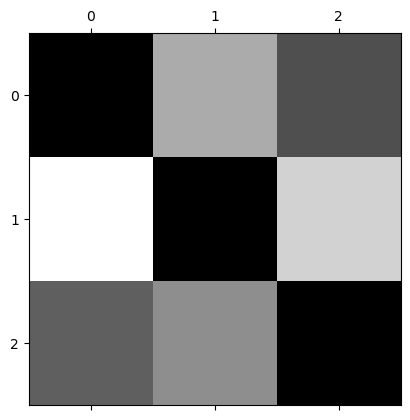

In [30]:
row_sums = np.sum(cfm, axis=1)
err_matrix = cfm/row_sums
np.fill_diagonal(err_matrix,0)
plt.matshow(err_matrix,cmap=plt.cm.gray)
plt.show()
#the ligher part show our model makes more mistakes in this area

## Try another model SVM.

In [31]:
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
param_grid = [

    {
        'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
        'multi_class':['ovr']
    },
    {
        'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
        'multi_class':["crammer_singer"]
    }

]
X_train2, X_test2, y_train2, y_test2 = train_test_split(\
                X_sm1, y_sm1, test_size=0.3,\
                    random_state=0)
grid_search = GridSearchCV(svm_model,param_grid=param_grid,cv=5,n_jobs=-1,scoring='accuracy')

In [32]:
grid_search.fit(X_train2,y_train2)

GridSearchCV(cv=5, estimator=LinearSVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                          'multi_class': ['ovr']},
                         {'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                          'multi_class': ['crammer_singer']}],
             scoring='accuracy')

In [33]:
grid_search.best_params_

{'C': 1, 'multi_class': 'ovr'}

In [34]:
svm_model_best = LinearSVC(C=1,multi_class='ovr')

In [35]:
svm_model_best.fit(X_train2,y_train2)

LinearSVC(C=1)

In [36]:
y_predicted2= svm_model_best.predict(X_test2)

## We can tell from the result, SVM preforms better overall compared with Bayes. However, in negative recall part Bayes is better.

In [37]:
print(classification_report(y_test2, y_predicted2))
print('accuracy of model:',svm_model_best.score(X_test2,y_test2))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      2752
           1       0.83      0.78      0.80      2750
           2       0.73      0.79      0.76      2759

    accuracy                           0.80      8261
   macro avg       0.80      0.80      0.80      8261
weighted avg       0.80      0.80      0.80      8261

accuracy of model: 0.8001452608643022


## To avoid model overfitting, we use voting classifier to build a new model based on models we built before.

In [38]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators=[
    ('bayes_clf',MultinomialNB(alpha=0.5)),
    ('svm_clf',LinearSVC(C=0.8,multi_class='ovr'))],
                              voting='hard'
)

In [39]:
voting_clf.fit(X_train1,y_train1)
y_predicted_final= voting_clf.predict(X_test1)
print(classification_report(y_test1, y_predicted_final))

              precision    recall  f1-score   support

    negative       0.74      0.88      0.80      2752
     neutral       0.72      0.70      0.71      2780
    positive       0.86      0.72      0.79      2729

    accuracy                           0.77      8261
   macro avg       0.77      0.77      0.77      8261
weighted avg       0.77      0.77      0.77      8261



## Here we deploy LDA to get some details why customers have negative sentiment

In [40]:
stop=stopwords.words('english')
tf_vectorizer_lad = CountVectorizer(min_df=10, stop_words=stop)
tf = tf_vectorizer_lad.fit_transform(preprocessed_data['text'])
X_train_new, X_test_new = train_test_split(\
                tf, test_size=0.1, random_state=0)
corpus = gensim.matutils.Sparse2Corpus(X_train_new, \
                            documents_columns=False)
id2word={idx:w for idx, w in \
         enumerate(tf_vectorizer_lad.get_feature_names())}
dictionary = corpora.Dictionary.from_corpus(corpus, \
                            id2word=id2word)
NUM_TOPICS = 3

ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, \
                            id2word=id2word, \
                            iterations=30)

topics = ldamodel.print_topics(num_words=20)
for topic in topics:
    print(topic)
    print("\n")

C:\Users\hcy\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(0, '0.041*"flight" + 0.021*"service" + 0.018*"customer" + 0.015*"hours" + 0.012*"thank" + 0.012*"cancelled" + 0.011*"hour" + 0.011*"gate" + 0.011*"get" + 0.011*"hold" + 0.010*"call" + 0.009*"waiting" + 0.009*"plane" + 0.008*"late" + 0.008*"delayed" + 0.008*"still" + 0.008*"amp" + 0.008*"got" + 0.007*"im" + 0.007*"flightled"')


(1, '0.038*"flight" + 0.023*"thanks" + 0.016*"flights" + 0.013*"cancelled" + 0.013*"get" + 0.008*"im" + 0.007*"like" + 0.007*"help" + 0.007*"bag" + 0.007*"back" + 0.006*"one" + 0.006*"seat" + 0.006*"fly" + 0.006*"flightled" + 0.005*"going" + 0.005*"problems" + 0.005*"amp" + 0.005*"dont" + 0.005*"see" + 0.005*"online"')


(2, '0.023*"flight" + 0.018*"time" + 0.012*"please" + 0.012*"help" + 0.011*"get" + 0.010*"need" + 0.010*"us" + 0.009*"airline" + 0.008*"cant" + 0.008*"one" + 0.008*"flying" + 0.007*"would" + 0.006*"ticket" + 0.006*"love" + 0.006*"plane" + 0.006*"really" + 0.006*"im" + 0.006*"new" + 0.006*"guys" + 0.006*"first"')




In [41]:
pyLDAvis.enable_notebook()

## Use visualization to find best number of cluster and top words

In [42]:
lda_display = gensimvis.prepare(ldamodel, corpus, dictionary, sort_topics=True, R=20)
pyLDAvis.display(lda_display)

C:\Users\hcy\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


## Next step, we scrape data from one airline review website

In [43]:
# from selenium import webdriver
from selenium.webdriver.common.by import By
from seleniumwire import webdriver

## We foucs on two airlines 'Air Canada' and 'British Airways', and get 2000 data for each airline.

In [44]:
import time
def get_review(page_number,airline_list):
    comment=[]
    
    for i in range(page_number):
        i+=1
        airline=airline_list[1]
        page_url='https://www.airlinequality.com/airline-reviews/'+str(airline)+'/page/'+str(i)+'/?sortby=post_date%3ADesc&pagesize=100'
        driver.get(page_url)
        input1=driver.find_elements(By.XPATH,"//div[contains(@class,'text_content')]")
        for a in input1:
            comment.append(a.text)
        time.sleep(1)

    for i in range(page_number):
        i+=1
        airline=airline_list[2]
        page_url='https://www.airlinequality.com/airline-reviews/'+str(airline)+'/page/'+str(i)+'/?sortby=post_date%3ADesc&pagesize=100'
        driver.get(page_url)
        input1=driver.find_elements(By.XPATH,"//div[contains(@class,'text_content')]")
        for a in input1:
            comment.append(a.text)
        time.sleep(1)
    
    return comment
        

In [45]:
executable_path = 'chromedriver.exe'
driver = webdriver.Chrome(executable_path=executable_path)
airline_list=['lufthansa','air-canada','british-airways']
page_number=20
comment=get_review(page_number,airline_list)
driver.quit()
len(comment)

C:\Users\hcy\anaconda3\lib\site-packages\seleniumwire\webdriver.py:218: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  super().__init__(*args, **kwargs)


3900

In [46]:
comment_dic = {'text':comment}

In [47]:
comment_dataframe=pd.DataFrame(comment_dic)

In [48]:
comment_dataframe

,text
0,✅ Trip Verified | We had been dreading this fl...
1,Not Verified | I've been a long time user of A...
2,"✅ Trip Verified | Plane was tired but clean, s..."
3,✅ Trip Verified | Air Canada disappointed in s...
4,✅ Trip Verified | After waiting at the gate fo...
...,...
3895,✅ Verified Review | We were treated incredibly...
3896,✅ Verified Review | I was scheduled to be on B...
3897,✅ Verified Review | British Airways from Londo...
3898,We flew British Airways BA2678 from Gatwick to...


In [49]:
preprocessed_comment = comment_dataframe.apply(remove_mentions).apply(remove_http).apply(remove_punctuation).apply(lower_case).apply(remove_first_twowords)
clean_comment = []
for text in preprocessed_comment.text:
    clean = remove_stopwords(text)
    clean_comment.append(clean)
X_comment = clean_comment

In [50]:
final_data=pd.DataFrame({'text':X_comment})

In [51]:
final_data

,text
0,verified dreading flight negative reviews took...
1,ive long time user air canada flight passes wo...
2,verified plane tired clean staff dreadful saw ...
3,verified air canada disappointed many ways sch...
4,verified waiting gate one hour plane arrived l...
...,...
3895,review treated incredibly well staff made trip...
3896,review scheduled ba 114 jfk lhr 17th may condu...
3897,review british airways london heathrow new yor...
3898,british airways ba2678 gatwick dubrovnik 26th ...


## After scraping data from website, we also clean data.

In [52]:
tfidf_vect_comment = TfidfVectorizer(min_df=10)
dtm_comment = tfidf_vect.transform(final_data['text'])

In [53]:
voc_lookup1={tfidf_vect.vocabulary_[word]:word \
            for word in tfidf_vect.vocabulary_}

print("\nOriginal text: \n"+final_data["text"][0])

print("\ntfidf weights: \n")
doc1=dtm_comment[0].toarray()[0]
print("Vectorized document shape: ", doc1.shape, "\n")

# get index of top 20 words
print("top words:")
top_words=(doc1.argsort())[::-1][0:20]
for i in top_words:
    print("{0}:\t{1:.3f}".format(voc_lookup1[i], doc1[i]))


Original text: 
verified dreading flight negative reviews took couple minutes check business class get fast track maple leaf lounge great smooth flight attentive fas middle seats thing didnt like fact divider didnt go couldnt communicate well great film selection food not first class airlines weve flown perfectly nice no complaints would fly

tfidf weights: 

Vectorized document shape:  (1756,) 

top words:
class:	0.317
didnt:	0.286
great:	0.264
track:	0.219
couple:	0.212
fast:	0.210
complaints:	0.200
lounge:	0.195
middle:	0.193
fact:	0.191
flown:	0.190
weve:	0.176
thing:	0.174
food:	0.173
took:	0.166
couldnt:	0.162
business:	0.160
nice:	0.156
airlines:	0.151
seats:	0.145


## We have some overview of our comment, then we deploy the model we have trained before, the last one. Finally, we get results of those comment.

In [54]:
y_predicted_comment=voting_clf.predict(dtm_comment)

In [55]:
y_predicted_comment

array(['negative', 'negative', 'negative', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [56]:
comment_result=list(y_predicted_comment)

In [57]:
final_comment=final_data
final_comment['sentiment']=comment_result

In [58]:
final_comment

,text,sentiment
0,verified dreading flight negative reviews took...,negative
1,ive long time user air canada flight passes wo...,negative
2,verified plane tired clean staff dreadful saw ...,negative
3,verified air canada disappointed many ways sch...,negative
4,verified waiting gate one hour plane arrived l...,negative
...,...,...
3895,review treated incredibly well staff made trip...,positive
3896,review scheduled ba 114 jfk lhr 17th may condu...,negative
3897,review british airways london heathrow new yor...,negative
3898,british airways ba2678 gatwick dubrovnik 26th ...,negative


## From results, we can sum up Air Canada and British Airways have not good companies since most of their comments are negative.

In [59]:
overall_comment = final_comment.groupby(['sentiment']).agg({'sentiment':'count'})
overall_comment

,sentiment
sentiment,
negative,3693
neutral,13
positive,194


## Use LDA we have built before to find reason of customer hate those two companies and give companies some suggestions

In [60]:
from gensim.corpora import Dictionary
tf1 = tf_vectorizer_lad.transform(final_data['text'])
common_dictionary = dictionary.doc2bow(final_data['text'])
ldamodel.print_topics()

[(0,
  '0.041*"flight" + 0.021*"service" + 0.018*"customer" + 0.015*"hours" + 0.012*"thank" + 0.012*"cancelled" + 0.011*"hour" + 0.011*"gate" + 0.011*"get" + 0.011*"hold"'),
 (1,
  '0.038*"flight" + 0.023*"thanks" + 0.016*"flights" + 0.013*"cancelled" + 0.013*"get" + 0.008*"im" + 0.007*"like" + 0.007*"help" + 0.007*"bag" + 0.007*"back"'),
 (2,
  '0.023*"flight" + 0.018*"time" + 0.012*"please" + 0.012*"help" + 0.011*"get" + 0.010*"need" + 0.010*"us" + 0.009*"airline" + 0.008*"cant" + 0.008*"one"')]